In [1]:
from src.test import do_test
from src.train import do_train
from src.main import make

import os 
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger


torch:  1.12 ; cuda:  cu113
detectron2: 0.6


### TODOs:
- [x] plot collection of images together with groundtruth 
- [ ] fit on single image -> achive 100% accuracy
- [ ] understand evaluation function
- [ ] fit on 5 images -> 100% accuracy
- [ ] 

In [2]:
# hardcoded configs TODO: make configs dynamic
TRAIN_DATASET = "cell_acdc_train"
TEST_DATASET = "cell_acdc_test"
MODEL = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"  # TODO customize
BATCH_SIZE = 2
NUM_DL_WORKER = 2
BASE_LR = 0.00025
MAX_ITER = 200

logger = setup_logger(output="./log/main.log")

# register new data
if True:
    register_coco_instances(
        TRAIN_DATASET,
        {},
        "./data/dataInCOCO/train/cell_acdc_coco_ds.json",
        "./data/dataInCOCO/train/images",
    )
    register_coco_instances(
        TEST_DATASET,
        {},
        "./data/dataInCOCO/test/cell_acdc_coco_ds.json",
        "./data/dataInCOCO/test/images",
    )

# build model according to configs
cfg, model = make(
    model=MODEL,
    train_dataset=TRAIN_DATASET,
    test_dataset=TRAIN_DATASET,
    num_dataloader_worker=NUM_DL_WORKER,
    batch_size=BATCH_SIZE,
    base_lr=BASE_LR,
    max_iter=MAX_ITER,
)

#logger.info("Model:\n{}".format(model))

# initialize weights and biases
#wandb.init(project="activeCell-ACDC", sync_tensorboard=True)

# run training
#do_train(cfg, model, logger)

#run testing
print(cfg.MODEL.WEIGHTS)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
print(cfg.MODEL.WEIGHTS)
do_test(cfg, model, logger)



https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
./output/model_final.pth
WARNING [10/06 09:27:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/06 09:27:48 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./data/dataInCOCO/train/cell_acdc_coco_ds.json
[10/06 09:27:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 2            |
|            |              |
[10/06 09:27:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/06 09:27:48 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[10/06 09:27:48 d2.data.common]: Serialized dataset takes 0.00 MiB
[10/06 09:27:48 d2.evaluation.evaluator]

/home/ubuntu/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


OrderedDict([('bbox',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APs': nan,
               'APm': nan,
               'APl': nan})])

[09/28 16:25:09 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

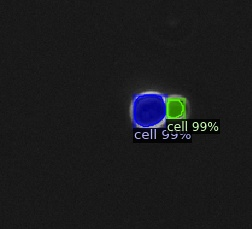

In [3]:
import os
import cv2

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

from IPython.display import Image
#Image(filename='./data/dataInCOCO/train/images/1_0.png')
im = cv2.imread("./data/dataInCOCO/train/images/1_0.png")

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imwrite("firstSegm.jpg",out.get_image()[:, :, ::-1])
Image(filename='firstSegm.jpg')

WARNING [09/28 16:05:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 16:05:26 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./data/dataInCOCO/train/cell_acdc_coco_ds.json


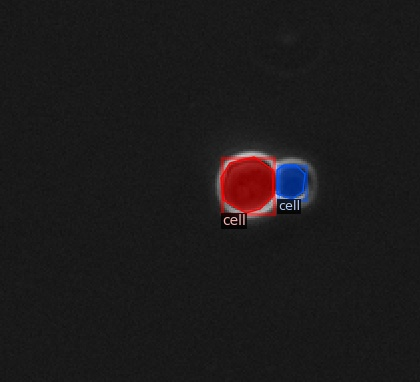

In [24]:
import json
import random

with open("./data/dataInCOCO/train/cell_acdc_coco_ds.json") as file:
    dict_ = json.load(file)
#print(dict_)

#for d in random.sample(dict_['images'], 1):
img = cv2.imread('./data/dataInCOCO/train/images/1_0.png')
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=2)
out = visualizer.draw_dataset_dict(DatasetCatalog.get(TRAIN_DATASET)[0])
cv2.imwrite("firstSegm.jpg",out.get_image()[:, :, ::-1])
Image(filename='firstSegm.jpg')

In [20]:
from detectron2.data import build_detection_train_loader
data_loader = build_detection_train_loader(cfg)

WARNING [09/28 15:59:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 15:59:33 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./data/dataInCOCO/train/cell_acdc_coco_ds.json
[09/28 15:59:33 d2.data.build]: Removed 0 images with no usable annotations. 1 images left.
[09/28 15:59:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/28 15:59:33 d2.data.build]: Using training sampler TrainingSampler
[09/28 15:59:33 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[09/28 15:59:33 d2.data.common]: Serialized dataset takes 0.00 MiB


In [21]:
data_loader

In [22]:
DatasetCatalog.get(TRAIN_DATASET)

WARNING [09/28 16:04:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 16:04:46 d2.data.datasets.coco]: Loaded 1 images in COCO format from ./data/dataInCOCO/train/cell_acdc_coco_ds.json


[{'file_name': './data/dataInCOCO/train/images/1_0.png',
  'height': 191,
  'width': 210,
  'image_id': 1,
  'annotations': [{'iscrowd': 0,
    'bbox': [111.0, 79.0, 26.0, 28.0],
    'category_id': 0,
    'segmentation': [[123.0,
      106.5,
      111.5,
      100.0,
      110.5,
      89.0,
      115.0,
      81.5,
      127.0,
      78.5,
      136.5,
      85.0,
      136.5,
      98.0,
      130.0,
      104.5,
      123.0,
      106.5]],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [139.0, 83.0, 14.0, 17.0],
    'category_id': 0,
    'segmentation': [[146.0,
      99.5,
      138.5,
      97.0,
      138.5,
      85.0,
      142.0,
      82.5,
      148.0,
      82.5,
      152.5,
      87.0,
      151.5,
      96.0,
      146.0,
      99.5]],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}]

In [ ]:
[{"image_id": 1, "category_id": 0, "bbox": [0.0, 41.88059997558594, 210.0, 0.017032623291015625], "score": 1.0, "segmentation": {"size": [191, 210], "counts": "^UW1"}}, {"image_id": 1, "category_id": 0, "bbox": [0.0, 69.19007873535156, 210.0, 1.52587890625e-05], "score": 1.0, "segmentation": {"size": [191, 210], "counts": "^UW1"}}, {"image_id": 1, "category_id": 0, "bbox": [0.0, 72.1396484375, 210.0, 0.0065155029296875], "score": 1.0, "segmentation": {"size": [191, 210], "counts": "^UW1"}}, {"image_id": 1, "category_id": 0, "bbox": [0.0, 29.75102996826172, 210.0, 2.288818359375e-05], "score": 1.0, "segmentation": {"size": [191, 210], "counts": "^UW1"}}, {"image_id": 1, "category_id": 0, "bbox": [0.0, 102.92118072509766, 210.0, 0.0038604736328125], "score": 1.0, "segmentation": {"size": [191, 210], "counts": "^UW1"}}]